<a href="https://colab.research.google.com/github/mz1119/cup-classification-model/blob/main/Cup_Detection_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Converting JSON to Masks (using Ellipses)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import json
from PIL import Image, ImageDraw
import math

In [ ]:
data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/via_project_23Jun2021_14h34m_json.json')
data_frame = data_frame.transpose().reset_index()[['filename','regions']]

data_frame['regions'][0][0]['shape_attributes']

print(data_frame.shape[0])

2690


In [ ]:
#limit size of data_frame
data_frame = data_frame[0:1]

In [ ]:
#Convert to Masks
counter = 0
for row in range(data_frame.shape[0]):
    print(counter)
    counter += 1
    #get name
    file_name = data_frame['filename'][row]

    #open image
    im = Image.open("/content/drive/My Drive/Blue Hill Cup Images/Cup_Image_Dataset/" + file_name).convert("L")
    imgdraw = ImageDraw.Draw(im) 
    #get size
    width, height = im.size
    
    
    #make whole screen black
    imgdraw.rectangle([0,0,width,height], fill = 0, outline = 0) 


    cx = round(data_frame['regions'][row][0]['shape_attributes']['cx'])
    cy = round(data_frame['regions'][row][0]['shape_attributes']['cy'])
    rx = round(data_frame['regions'][row][0]['shape_attributes']['rx'])
    ry = round(data_frame['regions'][row][0]['shape_attributes']['ry'])
    theta = data_frame['regions'][row][0]['shape_attributes']['theta'] # in radians, will need to be converted to degrees later
    
    ellipse_bbox = [(0,0),(2*rx,2*ry)]

    ellipse_image = Image.new('L', (2*rx, 2*ry) , color = 0)

    ellipse_draw = ImageDraw.Draw(ellipse_image)
    ellipse_draw.ellipse(ellipse_bbox, fill = 1, outline = 1, width = 3)

    ellipse_image = ellipse_image.rotate(-math.degrees(theta), expand = 1)

    ellipse_width, ellipse_height = ellipse_image.size

    x_diff = int((ellipse_width - 2*rx)/2)
    y_diff = int((ellipse_height - 2*ry)/2)

    im.paste(ellipse_image, (cx-rx-x_diff,cy-ry-y_diff))
    
    im.save("/content/drive/My Drive/Blue Hill Cup Images/Cup_Image_Masks_Dataset/ellipse_mask_" + file_name[:-4] + "PNG", quality = 95)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

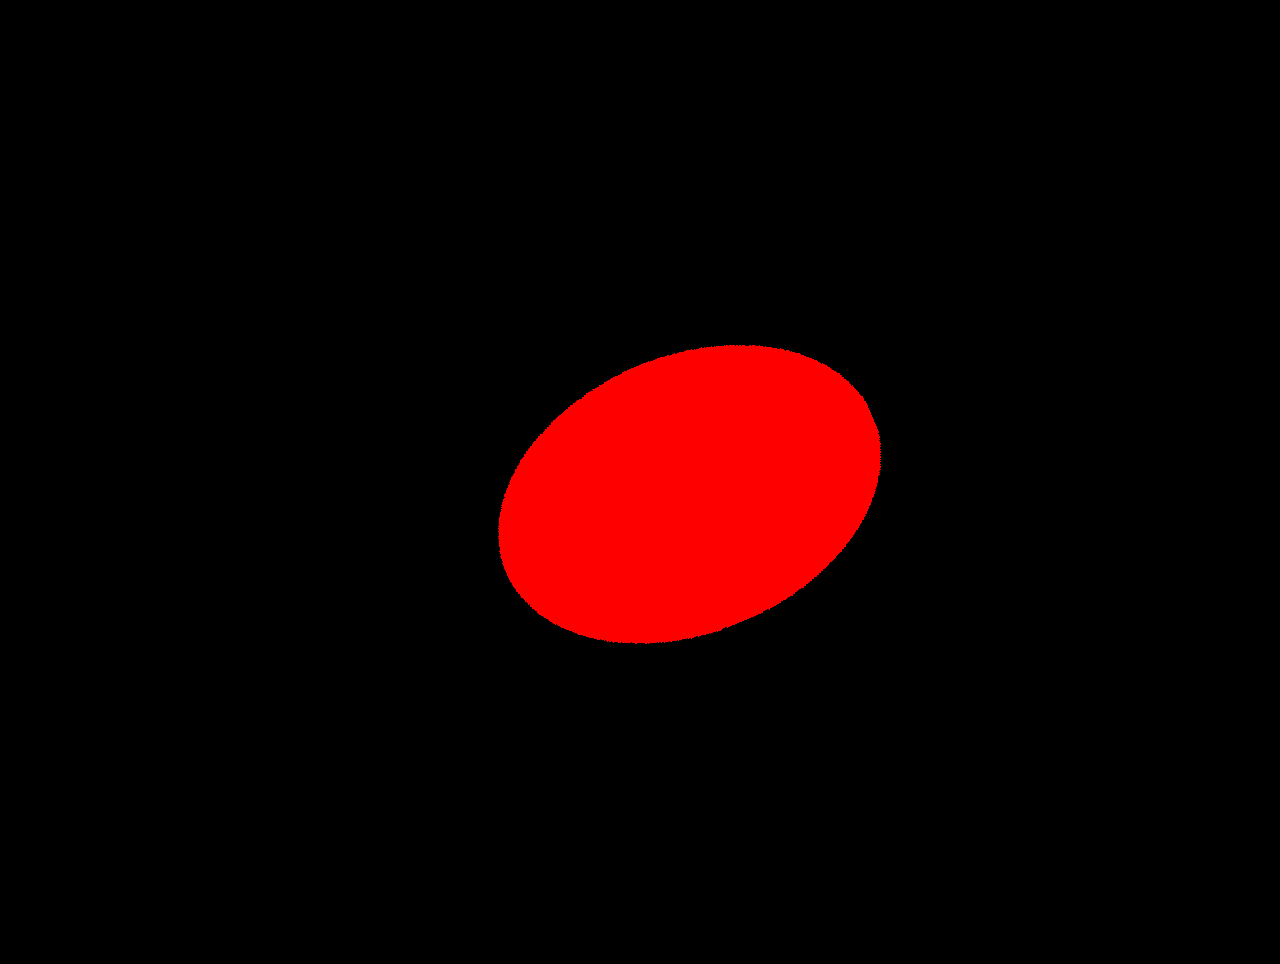

In [ ]:
  im.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    0, 255, 0, # index 2 is green
])

im

# Cup Edge Detection and Conversion Model

In [ ]:
%%shell

pip install cython
# Install pycocotools, the version by default in Colab
# has a bug fixed in https://github.com/cocodataset/cocoapi/pull/354
pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-46916twg
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-46916twg
  Created wheel for pycocotools: filename=pycocotools-2.0-cp37-cp37m-linux_x86_64.whl size=263905 sha256=0e92576cc1038eb6628090f5798118e510b1966b5fe4e4a7e4a87334efb174a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-on3bdyxu/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing installation: pycocotools 2.0.2
    Uninstalling pycocotools-2.0.2:
      Successfully uninstalled pycocotools-2.0.2


L
True True False False


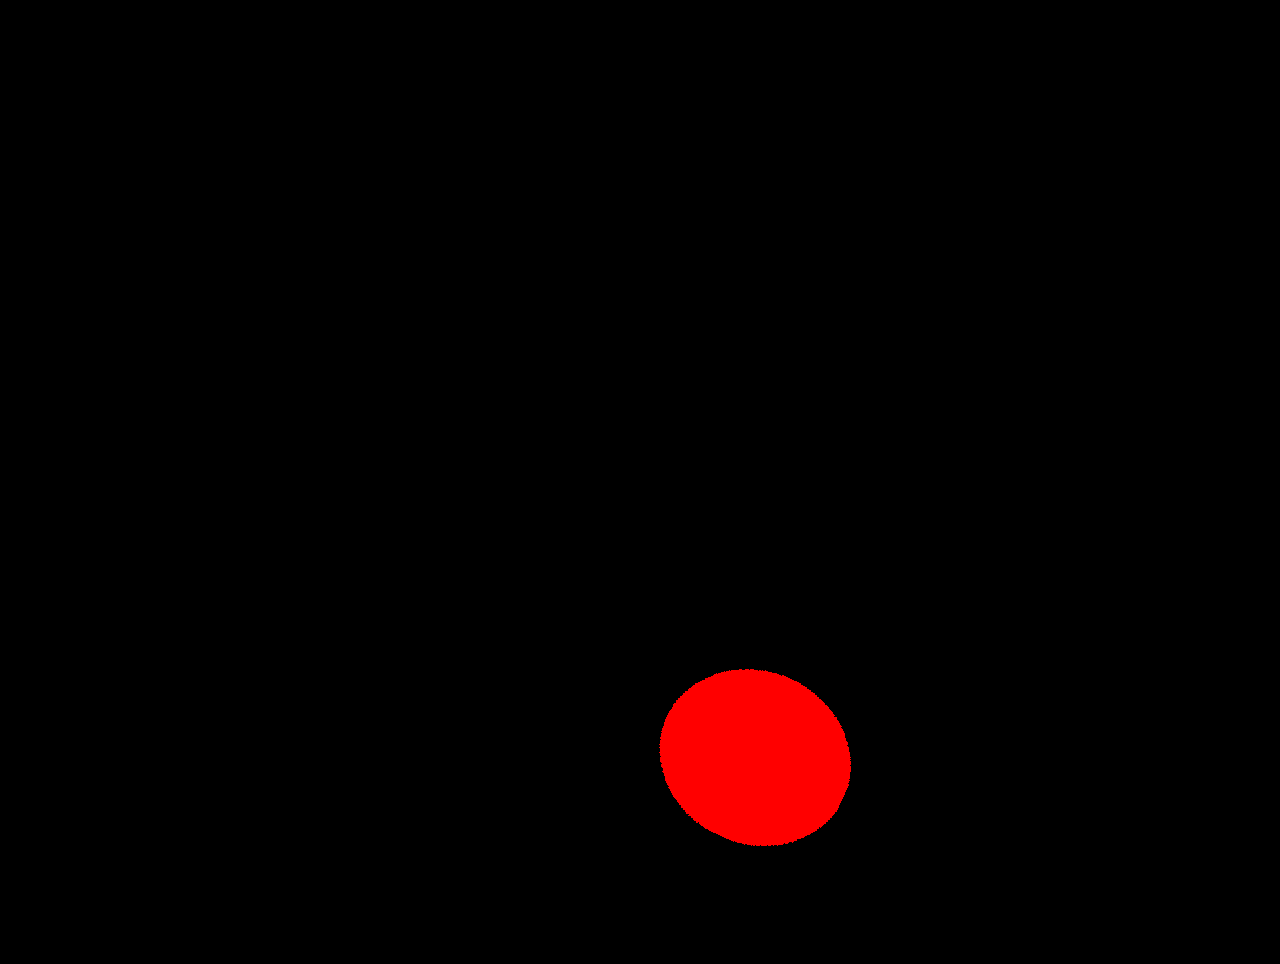

In [ ]:
from PIL import Image
import numpy as np

with Image.open("/content/drive/My Drive/Blue Hill Cup Images/Cup_Image_Masks_Dataset/ellipse_mask_20210623_152218_Image.PNG") as im:
    load_variable = im.load()
print(im.mode)
mask_list = np.array(im)
#check if background, line, and shaker outline are in list
print(0 in mask_list, 1 in mask_list, 2 in mask_list, 3 in mask_list)

im.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    0, 255, 0, # index 2 is green
])

im

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image

class detectionDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Cup_Image_Dataset"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "Cup_Image_Masks_Dataset"))))

    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "Cup_Image_Dataset", self.imgs[idx])
        mask_path = os.path.join(self.root, "Cup_Image_Masks_Dataset", self.masks[idx])
        #print(img_path)

        img = Image.open(img_path).convert("RGB")
        # mask not converted to RGB, color mode should be "L", only has one channel, greyscale
        # each instance/class corresponds to different pixel calue
        # with 0 being background
        
        #load fully opens the picture, making it "L" mode and not losing any values
        with Image.open(mask_path) as mask:
          load_variable = mask.load()
          mask = mask
        
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])


        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.masks)

In [ ]:
detect_dataset = detectionDataset("/content/drive/My Drive/Blue Hill Cup Images/")
print(len(detect_dataset))
# for i in range(len(detect_dataset)):
#     print(i)
#     print(detect_dataset[i])

2690


In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    detect_model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = detect_model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    detect_model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = detect_model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    detect_model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return detect_model 

In [ ]:
%%shell

# Download TorchVision repo to use some files from
# references/detection
git clone https://github.com/pytorch/vision.git
cd vision
git checkout v0.3.0

cp references/detection/utils.py ../
cp references/detection/transforms.py ../
cp references/detection/coco_eval.py ../
cp references/detection/engine.py ../
cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 30364, done.
remote: Counting objects: 100% (2907/2907), done.
remote: Compressing objects: 100% (744/744), done.
remote: Total 30364 (delta 2219), reused 2742 (delta 2106), pack-reused 27457
Receiving objects: 100% (30364/30364), 38.14 MiB | 33.24 MiB/s, done.
Resolving deltas: 100% (22829/22829), done.
Note: checking out 'v0.3.0'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at be376084 version check against PyTorch's CUDA version


In [ ]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [ ]:
# use our dataset and defined transformations
detect_dataset = detectionDataset("/content/drive/My Drive/Blue Hill Cup Images/", get_transform(train=True))
detect_dataset_test = detectionDataset("/content/drive/My Drive/Blue Hill Cup Images/", get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(detect_dataset)).tolist()
detect_dataset = torch.utils.data.Subset(detect_dataset, indices[:-50])
detect_dataset_test = torch.utils.data.Subset(detect_dataset_test, indices[-50:])

# define training and validation data loaders
detect_data_loader = torch.utils.data.DataLoader(
    detect_dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

detect_data_loader_test = torch.utils.data.DataLoader(
    detect_dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
#  dataset has 3 classes - background, line, shaker
num_classes = 2

# get the model using our helper function
detect_model = get_instance_segmentation_model(num_classes)
# move model to the right device
detect_model.to(device)

# construct an optimizer
params = [p for p in detect_model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

cuda


In [ ]:
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(detect_model, optimizer, detect_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(detect_model, detect_data_loader_test, device=device)

torch.save(detect_model, "/content/drive/My Drive/Blue Hill Cup Images/Saved_Cup_Model.pth")
print('model saved')

Epoch: [0]  [   0/1320]  eta: 0:23:47  lr: 0.000010  loss: 5.3180 (5.3180)  loss_classifier: 0.7818 (0.7818)  loss_box_reg: 0.1551 (0.1551)  loss_mask: 4.3381 (4.3381)  loss_objectness: 0.0414 (0.0414)  loss_rpn_box_reg: 0.0015 (0.0015)  time: 1.0817  data: 0.4646  max mem: 2700
Epoch: [0]  [  10/1320]  eta: 0:13:18  lr: 0.000060  loss: 4.5189 (4.1170)  loss_classifier: 0.7243 (0.7012)  loss_box_reg: 0.1223 (0.1276)  loss_mask: 3.6523 (3.2597)  loss_objectness: 0.0235 (0.0256)  loss_rpn_box_reg: 0.0027 (0.0029)  time: 0.6094  data: 0.0541  max mem: 2975
Epoch: [0]  [  20/1320]  eta: 0:12:49  lr: 0.000110  loss: 1.5591 (2.7983)  loss_classifier: 0.5096 (0.5278)  loss_box_reg: 0.1298 (0.1354)  loss_mask: 0.9960 (2.1083)  loss_objectness: 0.0230 (0.0245)  loss_rpn_box_reg: 0.0019 (0.0023)  time: 0.5678  data: 0.0139  max mem: 2975
Epoch: [0]  [  30/1320]  eta: 0:12:40  lr: 0.000160  loss: 1.2116 (2.1811)  loss_classifier: 0.2110 (0.4042)  loss_box_reg: 0.1369 (0.1356)  loss_mask: 0.7083 (

In [ ]:
detect_model = torch.load("/content/drive/My Drive/Blue Hill Cup Images/Saved_Cup_Model.pth")

RuntimeError: ignored

In [ ]:
from PIL import Image, ImageDraw
import pandas as pd
from matplotlib.pyplot import imshow

#get device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

def save_converted_img(name, path, device):
    file_name = name
    img = Image.open("/content/drive/My Drive/Blue Hill Cup Images/Cup_Image_Dataset/" + file_name).convert("RGB")
    device = device

    #convert img to tensor
    PIL_to_tensor = transforms.Compose([
            transforms.ToTensor()
            ])
    img = PIL_to_tensor(img)

    # put the model in evaluation mode
    detect_model.eval()
    with torch.no_grad():
        prediction = detect_model([img.to(device)])

    #get images and mask
    test_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
    mask_img = Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

    #make black pixels on mask transparent
    mask_img = mask_img.convert("RGBA")
    datas = mask_img.getdata()
    newData = []
    for item in datas:
        if item[0] <= 100 and item[1] <= 100 and item[2] <= 100:
            newData.append((0, 0, 0, 255)) #black
        elif item[0] == item[1] == item[2]:
            newData.append((255, 255, 255, 0)) #transparent
        else:
            newData.append(item)
    mask_img.putdata(newData)

    #overlay partial transparent mask_img over test_img
    test_img.paste(mask_img, (0, 0), mask_img)

    #get shape of bounding box
    bbox_shape = []
    for counter in range(prediction[0]['boxes'][0].size()[0]):
      bbox_shape.append(prediction[0]['boxes'][0][counter].item())

    test_img = test_img.crop(tuple(bbox_shape))

    #imshow(np.array(test_img))  
    test_img.save("/content/drive/My Drive/Blue Hill Cup Images/Converted_Cup_Images_Dataset/converted_" + file_name[:-4] + "PNG", quality = 95)

#import json
data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/via_project_23Jun2021_14h34m_json.json')
data_frame = data_frame.transpose().reset_index()[['filename','regions']]

for row in range(data_frame.shape[0]):
    print('progress: '+ str(row) + '/' + str(data_frame.shape[0]))
    save_converted_img(data_frame['filename'][row], "/content/drive/My Drive/Blue Hill Cup Images/Cup_Image_Dataset/", device)

cuda
progress: 0/2690


KeyboardInterrupt: ignored

# Milk/Water Cup Topping Classification

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

In [ ]:
#used https://www.convertcsv.com/csv-to-json.htm to convert from csv exported from excel

data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/MilkWaterJSON.json')
data_frame

,file_name,topping_type
0,20210623_105948_Image.jpeg,no_topping
1,20210623_105954_Image.jpeg,no_topping
2,20210623_105956_Image.jpeg,no_topping
3,20210623_105958_Image.jpeg,no_topping
4,20210623_105959_Image.jpeg,no_topping
...,...,...
1057,20210626_144818_Image.jpeg,ice_and_topping
1058,20210626_144819_Image.jpeg,ice_and_topping
1059,20210626_144820_Image.jpeg,ice_and_topping
1060,20210626_144821_Image.jpeg,ice_and_topping


In [ ]:
class classificationDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/MilkWaterJSON.json')
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        img_id = self.data_frame.iloc[index, 0]
        print(img_id) 
        img = Image.open(os.path.join(self.root_dir, 'converted_' + img_id[:-4] + "PNG"))

        #use RGB for now
        img = img.convert("RGB")

        ref_var = self.data_frame.iloc[index, 1]

        if ref_var == 'no_topping':
            y_label = torch.tensor(0)
        elif ref_var == 'has_topping':
            y_label = torch.tensor(1)
        elif ref_var == 'has_ice':
            y_label = torch.tensor(2)
        elif ref_var == 'ice_and_topping':
            y_label = torch.tensor(3)


        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((366,366)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            #transforms.Grayscale(1),
        ]
    )

In [ ]:
class_dataset = classificationDataset("/content/drive/My Drive/Blue Hill Cup Images/Converted_Cup_Images_Dataset/")
# for i in range(len(class_dataset)):
#     print(class_dataset[i])

In [ ]:
batch_size = 4
num_workers = 2

class_dataset = classificationDataset("/content/drive/My Drive/Blue Hill Cup Images/Converted_Cup_Images_Dataset/", transform = transform)
class_trainset, class_validationset = torch.utils.data.random_split(class_dataset,[len(class_dataset)- 50, 50])

class_trainloader = torch.utils.data.DataLoader(dataset=class_trainset, shuffle = True, batch_size=batch_size,num_workers=num_workers)

class_validationloader = torch.utils.data.DataLoader(dataset=class_validationset, shuffle = True, batch_size=batch_size,num_workers=num_workers)

classes = ('no_topping','has_topping','has_ice','ice_and_topping')


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models

net = torchvision.models.resnext101_32x8d(pretrained = True)

net = net.to(device)
#print(list(net.children()))

Downloading: "https://download.pytorch.org/models/resnext101_32x8d-8ba56ff5.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-8ba56ff5.pth


In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    print("epoch: " + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(class_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

torch.save(net, "/content/drive/My Drive/Blue Hill Cup Images/Milk_and_Water_Classification_Saved_Model.pth")
print('Finished Training')

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Finished Training


In [ ]:
net = torch.load("/content/drive/My Drive/Blue Hill Cup Images/Milk_and_Water_Classification_Saved_Model.pth")

20210623_133746_Image.jpeg
20210625_151911_Image.jpeg
20210623_105956_Image.jpeg
20210625_152102_Image.jpeg
20210623_114338_Image.jpeg
20210625_152632_Image.jpeg
20210626_143929_Image.jpeg
20210625_152451_Image.jpeg
20210625_102845_Image.jpeg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


20210626_143721_Image.jpeg


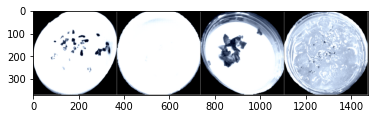

GroundTruth:  has_topping has_topping has_topping ice_and_topping


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(class_validationloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)
print(outputs)
print(torch.max(outputs, 1))
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

tensor([[ 1.7625e+01,  2.6113e+01,  9.4949e+00,  ...,  1.9849e-02,
          5.2356e-01, -1.5440e-01],
        [ 2.1243e+01,  2.8403e+01,  1.1587e+01,  ...,  1.6193e-02,
          5.8326e-01, -9.8760e-02],
        [ 2.4187e+01,  2.6082e+01,  6.9136e+00,  ...,  4.2154e-01,
          1.3854e+00, -4.4655e-01],
        [ 6.4537e+00,  9.2942e+00,  9.8120e+00,  ..., -3.5377e-01,
          2.2816e-02, -1.2683e-01]], device='cuda:0', grad_fn=<AddmmBackward>)
torch.return_types.max(
values=tensor([26.1126, 28.4034, 26.0825, 17.0428], device='cuda:0',
       grad_fn=<MaxBackward0>),
indices=tensor([1, 1, 1, 3], device='cuda:0'))
Predicted:  has_topping has_topping has_topping ice_and_topping


# Espresso Topping Classification

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

In [ ]:
#used https://www.convertcsv.com/csv-to-json.htm to convert from csv exported from excel
data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/EspressoJSON.json')
data_frame

,file_name,topping_type
0,20210623_151856_Image.jpeg,no_topping
1,20210623_151857_Image.jpeg,no_topping
2,20210623_151858_Image.jpeg,no_topping
3,20210623_151859_Image.jpeg,no_topping
4,20210623_151900_Image.jpeg,no_topping
...,...,...
388,20210626_145601_Image.jpeg,has_topping
389,20210626_145602_Image.jpeg,has_topping
390,20210626_145631_Image.jpeg,has_topping
391,20210626_145632_Image.jpeg,has_topping


In [ ]:
class classificationDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/EspressoJSON.json')
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        img_id = self.data_frame.iloc[index, 0]
        
        img = Image.open(os.path.join(self.root_dir, 'converted_' + img_id[:-4] + "PNG"))

        #use RGB for now
        img = img.convert("RGB")

        ref_var = self.data_frame.iloc[index, 1]

        if ref_var == 'no_topping':
            y_label = torch.tensor(0)
        elif ref_var == 'has_topping':
            y_label = torch.tensor(1)


        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((366,366)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            #transforms.Grayscale(1),
        ]
    )

In [ ]:
class_dataset = classificationDataset("/content/drive/My Drive/Blue Hill Cup Images/Converted_Cup_Images_Dataset/")
# for i in range(len(class_dataset)):
#     print(class_dataset[i])

In [ ]:
batch_size = 4
num_workers = 2

class_dataset = classificationDataset("/content/drive/My Drive/Blue Hill Cup Images/Converted_Cup_Images_Dataset/", transform = transform)
class_trainset, class_validationset = torch.utils.data.random_split(class_dataset,[len(class_dataset)- 50, 50])

class_trainloader = torch.utils.data.DataLoader(dataset=class_trainset, shuffle = True, batch_size=batch_size,num_workers=num_workers)

class_validationloader = torch.utils.data.DataLoader(dataset=class_validationset, shuffle = True, batch_size=batch_size,num_workers=num_workers)

classes = ('no_topping','has_topping')

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models

net = torchvision.models.resnext101_32x8d(pretrained = True)

net = net.to(device)
#print(list(net.children()))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    print("epoch: " + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(class_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

torch.save(net, "/content/drive/My Drive/Blue Hill Cup Images/Espresso_Classification_Saved_Model.pth")
print('Finished Training')

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Finished Training


In [ ]:
net = torch.load("/content/drive/My Drive/Blue Hill Cup Images/Espresso_Classification_Saved_Model.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


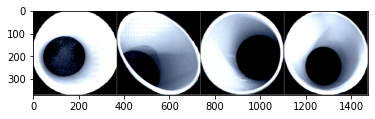

GroundTruth:  has_topping has_topping no_topping no_topping


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(class_validationloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  has_topping has_topping no_topping no_topping


# Latte Topping Classification

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

In [ ]:
#used https://www.convertcsv.com/csv-to-json.htm to convert from csv exported from excel
data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/LatteJSON.json')
data_frame

,file_name,topping_type
0,20210626_145842_Image.jpeg,no_topping
1,20210626_145843_Image.jpeg,no_topping
2,20210626_145844_Image.jpeg,no_topping
3,20210626_145845_Image.jpeg,no_topping
4,20210626_145846_Image.jpeg,no_topping
...,...,...
675,20210629_193642_Image.jpeg,ice_and_topping
676,20210629_193643_Image.jpeg,ice_and_topping
677,20210629_193644_Image.jpeg,ice_and_topping
678,20210629_193645_Image.jpeg,ice_and_topping


In [ ]:
class classificationDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/LatteJSON.json')
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        img_id = self.data_frame.iloc[index, 0]
        
        img = Image.open(os.path.join(self.root_dir, 'converted_' + img_id[:-4] + "PNG"))

        #use RGB for now
        img = img.convert("RGB")

        ref_var = self.data_frame.iloc[index, 1]

        if ref_var == 'no_topping':
            y_label = torch.tensor(0)
        elif ref_var == 'has_topping':
            y_label = torch.tensor(1)
        elif ref_var == 'has_ice':
            y_label = torch.tensor(2)
        elif ref_var == 'ice_and_topping':
            y_label = torch.tensor(3)


        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((366,366)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            #transforms.Grayscale(1),
        ]
    )

In [ ]:
class_dataset = classificationDataset("/content/drive/My Drive/Blue Hill Cup Images/Converted_Cup_Images_Dataset/")
# for i in range(len(class_dataset)):
#     print(class_dataset[i])

In [ ]:
batch_size = 4
num_workers = 2

class_dataset = classificationDataset("/content/drive/My Drive/Blue Hill Cup Images/Converted_Cup_Images_Dataset/", transform = transform)
class_trainset, class_validationset = torch.utils.data.random_split(class_dataset,[len(class_dataset)- 50, 50])

class_trainloader = torch.utils.data.DataLoader(dataset=class_trainset, shuffle = True, batch_size=batch_size,num_workers=num_workers)

class_validationloader = torch.utils.data.DataLoader(dataset=class_validationset, shuffle = True, batch_size=batch_size,num_workers=num_workers)

classes = ('no_topping','has_topping','has_ice','ice+topping')


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models

net = torchvision.models.resnext101_32x8d(pretrained = True)


net = net.to(device)
#print(list(net.children()))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    print("epoch: " + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(class_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

torch.save(net, "/content/drive/My Drive/Blue Hill Cup Images/Latte_Classification_Saved_Model.pth")
print('Finished Training')

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Finished Training


In [ ]:
net = torch.load("/content/drive/My Drive/Blue Hill Cup Images/Latte_Classification_Saved_Model.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


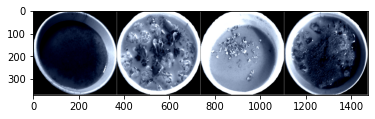

GroundTruth:  has_topping ice+topping has_topping ice+topping


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(class_validationloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  no_topping ice+topping has_topping ice+topping


# Coffee Topping Classification

In [ ]:
import os
import numpy as np
import torch
import torch.utils.data
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import pandas as pd

In [ ]:
#used https://www.convertcsv.com/csv-to-json.htm to convert from csv exported from excel
data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/CoffeeJSON.json')
data_frame

,file_name,topping_type
0,20210625_155152_Image.jpeg,has_ice
1,20210625_155153_Image.jpeg,has_ice
2,20210625_155154_Image.jpeg,has_ice
3,20210625_155155_Image.jpeg,has_ice
4,20210625_155156_Image.jpeg,has_ice
...,...,...
550,20210629_210553_Image.jpeg,ice_and_topping
551,20210629_210554_Image.jpeg,ice_and_topping
552,20210629_210555_Image.jpeg,ice_and_topping
553,20210629_210557_Image.jpeg,ice_and_topping


In [ ]:
class classificationDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.data_frame = pd.read_json('/content/drive/My Drive/Blue Hill Cup Images/CoffeeJSON.json')
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, index):
        img_id = self.data_frame.iloc[index, 0]
        
        img = Image.open(os.path.join(self.root_dir, 'converted_' + img_id[:-4] + "PNG"))

        #use RGB for now
        img = img.convert("RGB")

        ref_var = self.data_frame.iloc[index, 1]

        if ref_var == 'no_topping':
            y_label = torch.tensor(0)
        elif ref_var == 'has_topping':
            y_label = torch.tensor(1)
        elif ref_var == 'has_ice':
            y_label = torch.tensor(2)
        elif ref_var == 'ice_and_topping':
            y_label = torch.tensor(3)


        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
transform = transforms.Compose(
        [
            transforms.Resize((366,366)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
            #transforms.Grayscale(1),
        ]
    )

In [ ]:
class_dataset = classificationDataset("/content/drive/My Drive/Blue Hill Cup Images/Converted_Cup_Images_Dataset/")
# for i in range(len(class_dataset)):
#     print(class_dataset[i])

In [ ]:
batch_size = 4
num_workers = 2

class_dataset = classificationDataset("/content/drive/My Drive/Blue Hill Cup Images/Converted_Cup_Images_Dataset/", transform = transform)
class_trainset, class_validationset = torch.utils.data.random_split(class_dataset,[len(class_dataset)- 50, 50])

class_trainloader = torch.utils.data.DataLoader(dataset=class_trainset, shuffle = True, batch_size=batch_size,num_workers=num_workers)

class_validationloader = torch.utils.data.DataLoader(dataset=class_validationset, shuffle = True, batch_size=batch_size,num_workers=num_workers)

classes = ('no_topping','has_topping','has_ice','ice+topping')


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models

net = torchvision.models.resnext101_32x8d(pretrained = True)

net = net.to(device)
#print(list(net.children()))

In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.005, momentum=0.9)

In [ ]:
for epoch in range(10):  # loop over the dataset multiple times
    print("epoch: " + str(epoch))
    running_loss = 0.0
    for i, data in enumerate(class_trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

torch.save(net, "/content/drive/My Drive/Blue Hill Cup Images/Coffee_Classification_Saved_Model.pth")
print('Finished Training')

epoch: 0
epoch: 1
epoch: 2
epoch: 3
epoch: 4
epoch: 5
epoch: 6
epoch: 7
epoch: 8
epoch: 9
Finished Training


In [ ]:
net = torch.load("/content/drive/My Drive/Blue Hill Cup Images/Coffee_Classification_Saved_Model.pth")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


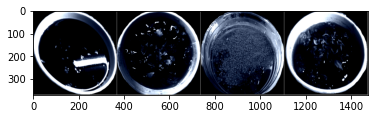

GroundTruth:  has_topping ice+topping ice+topping ice+topping


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(class_validationloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
outputs = net(images.to(device))

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:  has_topping ice+topping ice+topping ice+topping
